# Trabajando con los FLAT
Primero importamos los módulos

In [5]:
from pathlib import Path
from ccdproc import ImageFileCollection, CCDData, subtract_overscan, trim_image

from astropy import units as u

from matplotlib import pyplot as plt
import numpy as np
from astropy.stats import mad_std

from functions import show_image, find_nearest_dark_exposure

Y ahora definimos nuevamente las rutas a nuestros datos

In [2]:
#- Define la ruta a los datos "crudos"
cryo_path = Path('example-cryo-LFC')

#- Define la ruta de las imágenes calibradas
calibrated_data = Path('example-reduced')

#- Selecciona las imágenes 
files = ImageFileCollection(cryo_path)
reduced_images = ImageFileCollection(calibrated_data)

#- Selecciona las imágenes dark combinadas
combined_dark_files = reduced_images.files_filtered(imagetyp='dark', combined=True)

flat_image_type = 'FLATFIELD'

Verificamos los tiempos de exposición en las imágenes dark

In [3]:
actual_exposure_times = set(h['exptime'] for h in reduced_images.headers(imagetyp='dark', combined=True))
actual_exposure_times


{7.0, 70.0, 300.0}

## Primero visualizamos una imagen flat

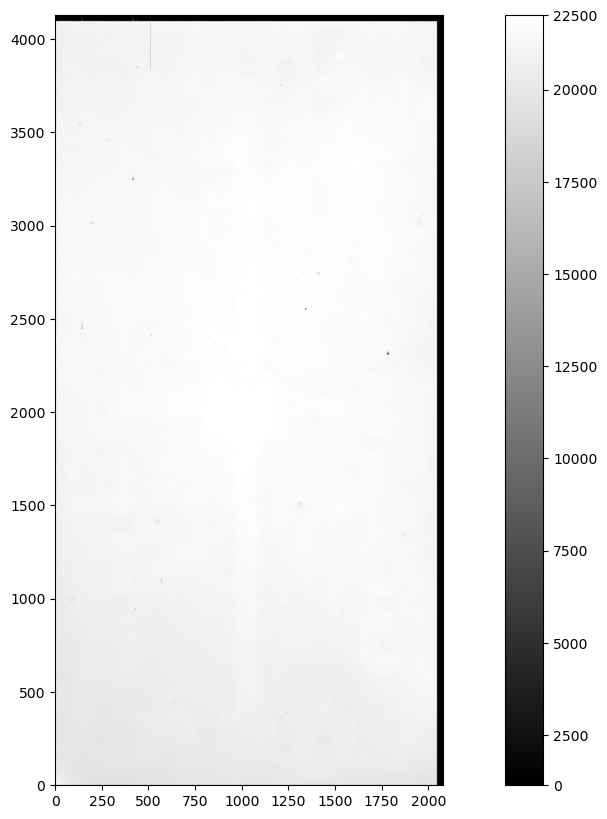

In [4]:
a_flat = CCDData.read(files.files_filtered(imagetyp='flatfield', include_path=True)[0], unit='adu')

show_image(a_flat, cmap='gray')

## Restando el overscan y recortando la imagen

Text(0.5, 1.0, 'Single flat frame, overscan subtracted and trimmed')

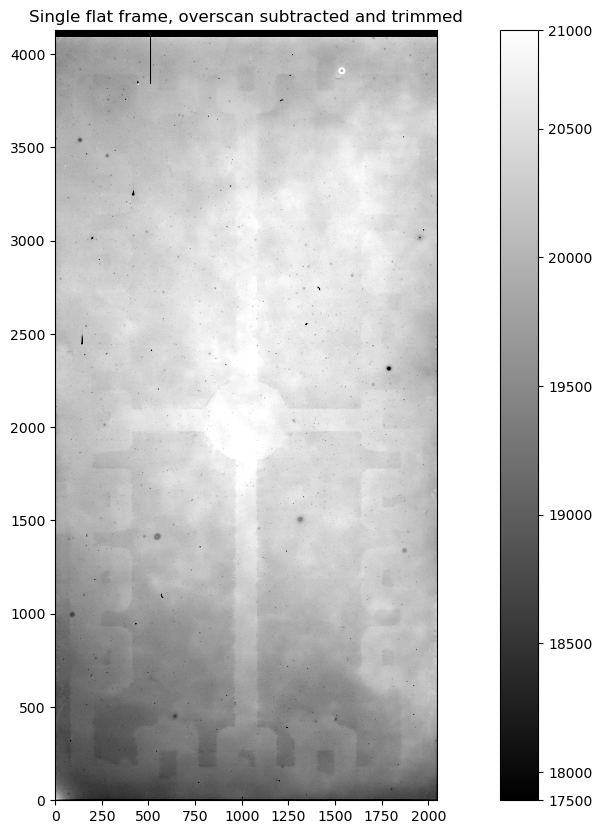

In [6]:
# Restar el overscan
a_flat_reduced = subtract_overscan(a_flat, overscan=a_flat[:, 2055:], median=True)

# Recortar
a_flat_reduced = trim_image(a_flat_reduced[:, :2048])

# Visualizar
show_image(a_flat_reduced, cmap='gray')
plt.title('Single flat frame, overscan subtracted and trimmed')

Y verificamos los tiempos de exposición en las imágenes flat crudas


In [7]:
set(files.summary['exptime'][files.summary['imagetyp'] == 'FLATFIELD'])

{7.0, 70.001, 70.011}

Obteniendo el tiempo de exposición de los flats

In [8]:
closest_dark = find_nearest_dark_exposure(a_flat_reduced, actual_exposure_times)
closest_dark

NameError: name 'np' is not defined

Creamos un diccionario con los dark combinados

In [10]:
combined_darks = {ccd.header['exptime']: ccd for ccd in reduced_images.ccds(imagetyp='dark', combined=True)}
combined_darks

{7.0: CCDData([[ 6.45250000e+04, -3.85333333e+02, -3.63000000e+02, ...,
           -4.00000000e+00,  0.00000000e+00, -4.00000000e+00],
          [-1.36000000e+02,  2.84666667e+02,  3.33000000e+02, ...,
           -2.66666667e+00, -5.00000000e+00, -2.33333333e+00],
          [-1.60000000e+01,  3.64666667e+02,  3.94333333e+02, ...,
           -1.00000000e+00,  1.00000000e+00, -3.33333333e-01],
          ...,
          [-5.00000000e+00,  2.43000000e+02,  2.43333333e+02, ...,
           -3.00000000e+00, -3.00000000e+00, -5.00000000e+00],
          [ 2.00000000e+00,  2.54666667e+02,  2.47666667e+02, ...,
           -1.00000000e+00, -1.33333333e+00, -1.00000000e+00],
          [ 0.00000000e+00,  2.52666667e+02,  2.46500000e+02, ...,
           -1.66666667e+00, -3.33333333e-01, -3.00000000e+00]],
         dtype='>f8', unit='adu'),
 300.0: CCDData([[ 6.45000000e+04,  6.81433333e+03,  7.21566667e+03, ...,
           -3.33333333e-01,  0.00000000e+00, -3.33333333e-01],
          [-1.37666667e+02,

Sustraemos la imagen dark de los flats

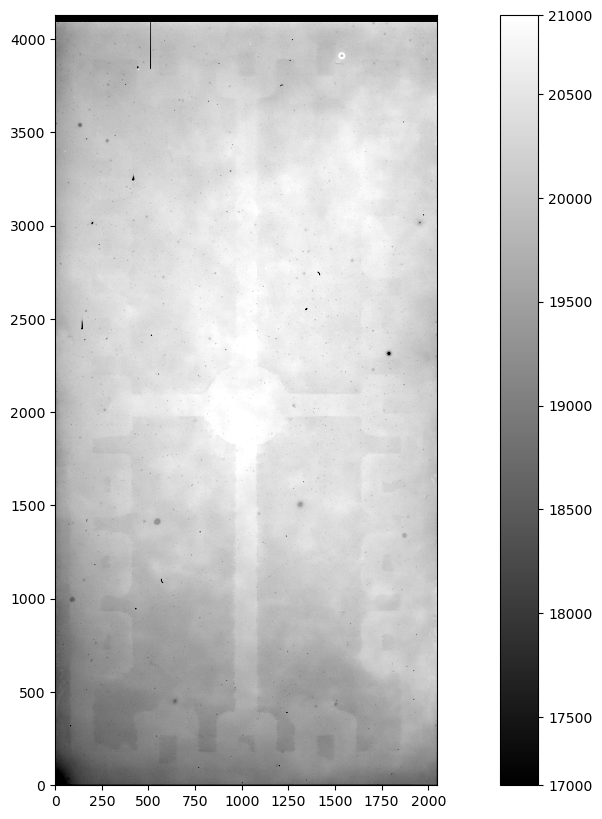

In [12]:
a_flat_reduced = ccdp.subtract_dark(a_flat_reduced, 
                                    combined_darks[closest_dark], 
                                    exposure_time='exptime', 
                                    exposure_unit=u.second, scale=False)

show_image(a_flat_reduced, cmap='gray')

Repitiendo para todos los archivos

In [13]:
for ccd, file_name in files.ccds(imagetyp='FLATFIELD',            # Just get the bias frames
                                         ccd_kwargs={'unit': 'adu'}, # CCDData requires a unit for the image if 
                                                                     # it is not in the header
                                         return_fname=True           # Provide the file name too.
                                        ):    
    # Subtract the overscan
    ccd = ccdp.subtract_overscan(ccd, overscan=ccd[:, 2055:], median=True)
    
    # Trim the overscan
    ccd = ccdp.trim_image(ccd[:, :2048])
    
    # Find the correct dark exposure
    closest_dark = find_nearest_dark_exposure(ccd, actual_exposure_times)
    
    # Subtract the dark current 
    ccd = ccdp.subtract_dark(ccd, combined_darks[closest_dark],
                             exposure_time='exptime', exposure_unit=u.second)

    # Save the result; there are some duplicate file names so pre-pend "flat"
    ccd.write(calibrated_data / ('flat-' + file_name))

# Combinando los flats
Primero separemos los flats de acuerdo a sus filtros.

Veamos qué filtros utilizan:

In [16]:
#- Actualizando el contenido de la carpeta
reduced_images.refresh()

#- Definiendo el tipo de imagen
flat_imagetyp = 'flatfield'

#- Buscando los filtros usados en este tipo de imagen
flat_filters = set(h['filter'] for h in reduced_images.headers(imagetyp=flat_imagetyp))
flat_filters

{"g'", "i'"}

## Comportamiento de la media y la mediana


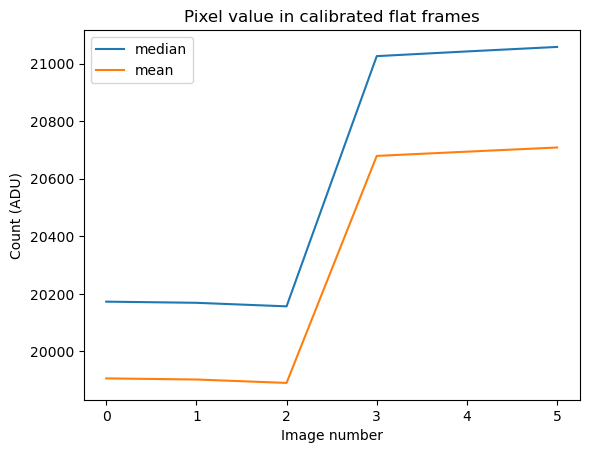

[20173.0, 20169.0, 20156.666666666668, 21026.0, 21042.333333333332, 21058.0]


In [20]:
median_count = [np.median(data) for data in reduced_images.data(imagetyp=flat_imagetyp)]
mean_count = [np.mean(data) for data in reduced_images.data(imagetyp=flat_imagetyp)]

plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')

plt.xlabel('Image number')
plt.ylabel('Count (ADU)')

plt.title('Pixel value in calibrated flat frames')
plt.legend()
plt.show()

print(median_count)

In [21]:
#- Función para invertir la mediana:
def inv_median(a):
    return 1 / np.median(a)

Y finalmente combinando los flats de acuerdo a sus filtros:

In [22]:
for filt in flat_filters:
    to_combine = reduced_images.files_filtered(imagetyp=flat_imagetyp, filter=filt, include_path=True)
    combined_flat = ccdp.combine(to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_flat.meta['combined'] = True
    flat_file_name = 'combined_flat_filter_{}.fits'.format(filt.replace("''", "p"))
    combined_flat.write(calibrated_data / flat_file_name)

INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


Verificando que se crearon los archivos:

In [23]:
#- Actualizando el contenido de la carpeta
reduced_images.refresh()
reduced_images.files_filtered(imagetyp=flat_imagetyp, combined=True)

array(["combined_flat_filter_g'.fits", "combined_flat_filter_i'.fits"],
      dtype='<U28')

## Visualizando

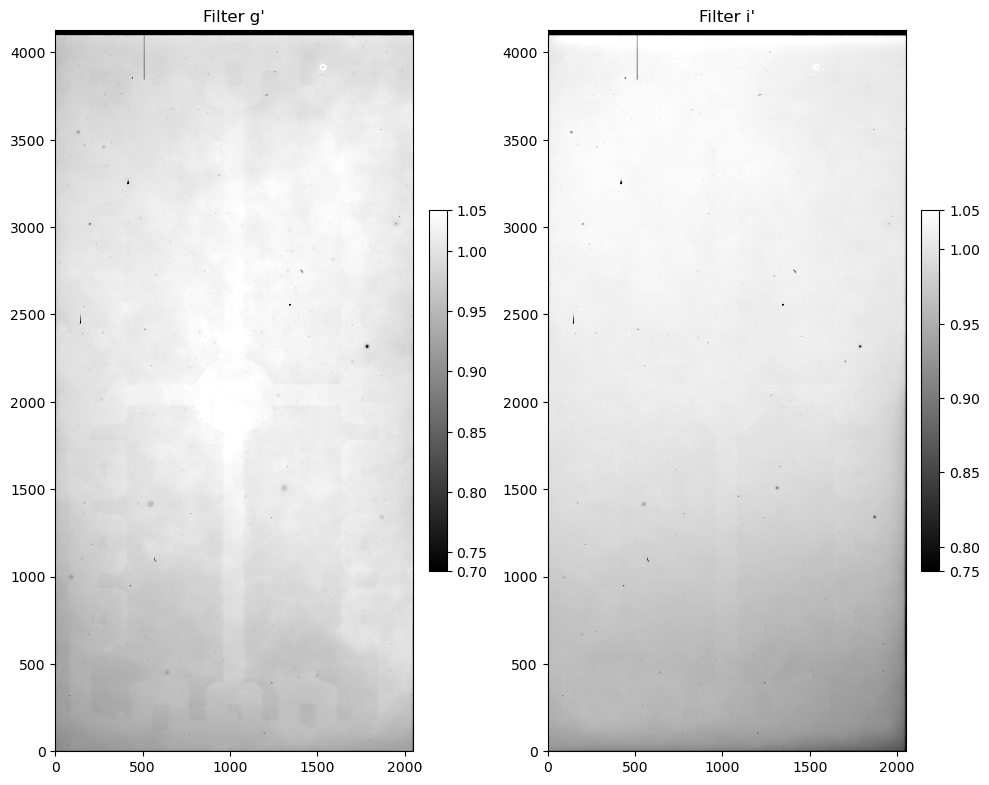

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20), tight_layout=True)

for ccd, axis in zip(reduced_images.ccds(imagetyp=flat_imagetyp, combined=True), axes):
    show_image(ccd.data, cmap='gray', fig=fig, ax=axis)
    title = "Filter {}".format(ccd.header['filter'])
    axis.set_title(title)

# Calibrando las imágenes

In [25]:
#- Definiendo algunas variables
science_imagetyp = 'object'
exposure = 'exptime'

Revisando las imágenes de objetos existentes

In [26]:
lights = files.summary[files.summary['imagetyp'] == science_imagetyp.upper()]
lights['date-obs', 'file', 'object', 'filter', exposure]

date-obs,file,object,filter,exptime
str10,str14,str7,str2,float64
2016-01-16,--,vv124_1,g',300.062
2016-01-16,--,vv124_1,i',300.014


Y ahora a las imágenes combinadas que creamos

In [27]:
combo_calibs = reduced_images.summary[reduced_images.summary['combined'].filled(False).astype('bool')]
combo_calibs['date-obs', 'file', 'imagetyp', 'object', 'filter', exposure]

date-obs,file,imagetyp,object,filter,exptime
str10,str28,str9,str6,str2,float64
2016-03-13,--,DARK,dark,r',7.0
2016-03-13,--,DARK,dark,r',300.0
2016-03-13,--,DARK,dark,r',70.0
2016-01-16,combined_flat_filter_g'.fits,FLATFIELD,flat_g,g',70.001
2016-01-16,combined_flat_filter_i'.fits,FLATFIELD,flat_i,i',7.0
2016-01-15,--,BIAS,bias,i',0.0


Creamos un diccionario con los flat combinados

In [30]:
combined_flats = {ccd.header['filter']: ccd for ccd in reduced_images.ccds(imagetyp=flat_imagetyp, combined=True)}
combined_flats

{"g'": CCDData([[ 2.00006526e-03,  7.76181700e-01,  7.97356421e-01, ...,
            7.93802709e-01,  7.85720031e-01,  7.43719007e-01],
          [ 2.47936101e-04,  8.68580975e-01,  8.96417584e-01, ...,
            8.86250363e-01,  8.77110985e-01,  8.58961138e-01],
          [ 3.30530282e-05,  8.55425634e-01,  9.02070096e-01, ...,
            8.90251380e-01,  8.87804829e-01,  8.55547836e-01],
          ...,
          [ 1.65770131e-05, -3.80159325e-04,  4.94925880e-05, ...,
            6.61505006e-05, -1.15758882e-04, -1.48720181e-04],
          [-2.31393138e-04, -3.47126522e-04,  9.91815880e-05, ...,
           -1.32164828e-04, -6.60577727e-05,  3.46129820e-08],
          [-8.26379080e-05,  1.15722272e-04,  1.15768432e-04, ...,
            2.64496447e-04,  9.92361446e-05,  1.48746398e-04]],
         dtype='>f8', unit='adu'),
 "i'": CCDData([[ 1.67910221e-03,  8.10961862e-01,  8.32777605e-01, ...,
            7.19414138e-01,  6.99676665e-01,  6.61469023e-01],
          [ 4.74124963e-05,

## Finalmente corrigiendo la imagen

In [31]:
#- Definiendo listas vacías
all_reds = []
light_ccds = []

#- Ciclo for para reducir las imágenes
for light, file_name in files.ccds(imagetyp=science_imagetyp, return_fname=True, ccd_kwargs=dict(unit='adu')):

    #- Incluyendo un nuevo elemento a la lista
    light_ccds.append(light)
    
    #- Restando overscan de la image de objeto
    reduced = ccdp.subtract_overscan(light, overscan=light[:, 2055:], median=True)
    
    #- Cortando la imagen de objeto
    reduced = ccdp.trim_image(reduced[:, :2048])

    #- Decidiendo cuál tiempo de exposición usar
    closest_dark = find_nearest_dark_exposure(reduced, combined_darks.keys())

    #- Corrigiendo por corriente oscura
    reduced = ccdp.subtract_dark(reduced, combined_darks[closest_dark],
                                 exposure_time=exposure, exposure_unit=u.second)
    
    #- Seleccionando el flat adecuado de acuerdo al filtro
    good_flat = combined_flats[reduced.header['filter']]

    #- Corrigiendo por flat
    reduced = ccdp.flat_correct(reduced, good_flat)

    #- Incluyendo un nuevo elemento a la lista
    all_reds.append(reduced)

    reduced.write(calibrated_data / file_name)

/opt/miniconda3/lib/python3.11/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/miniconda3/lib/python3.11/site-packages/astropy/nddata/nduncertainty.py:881: RuntimeWarning: invalid value encountered in divide
  (left + right + correlation_sign * corr)


## Visualizando los resultados

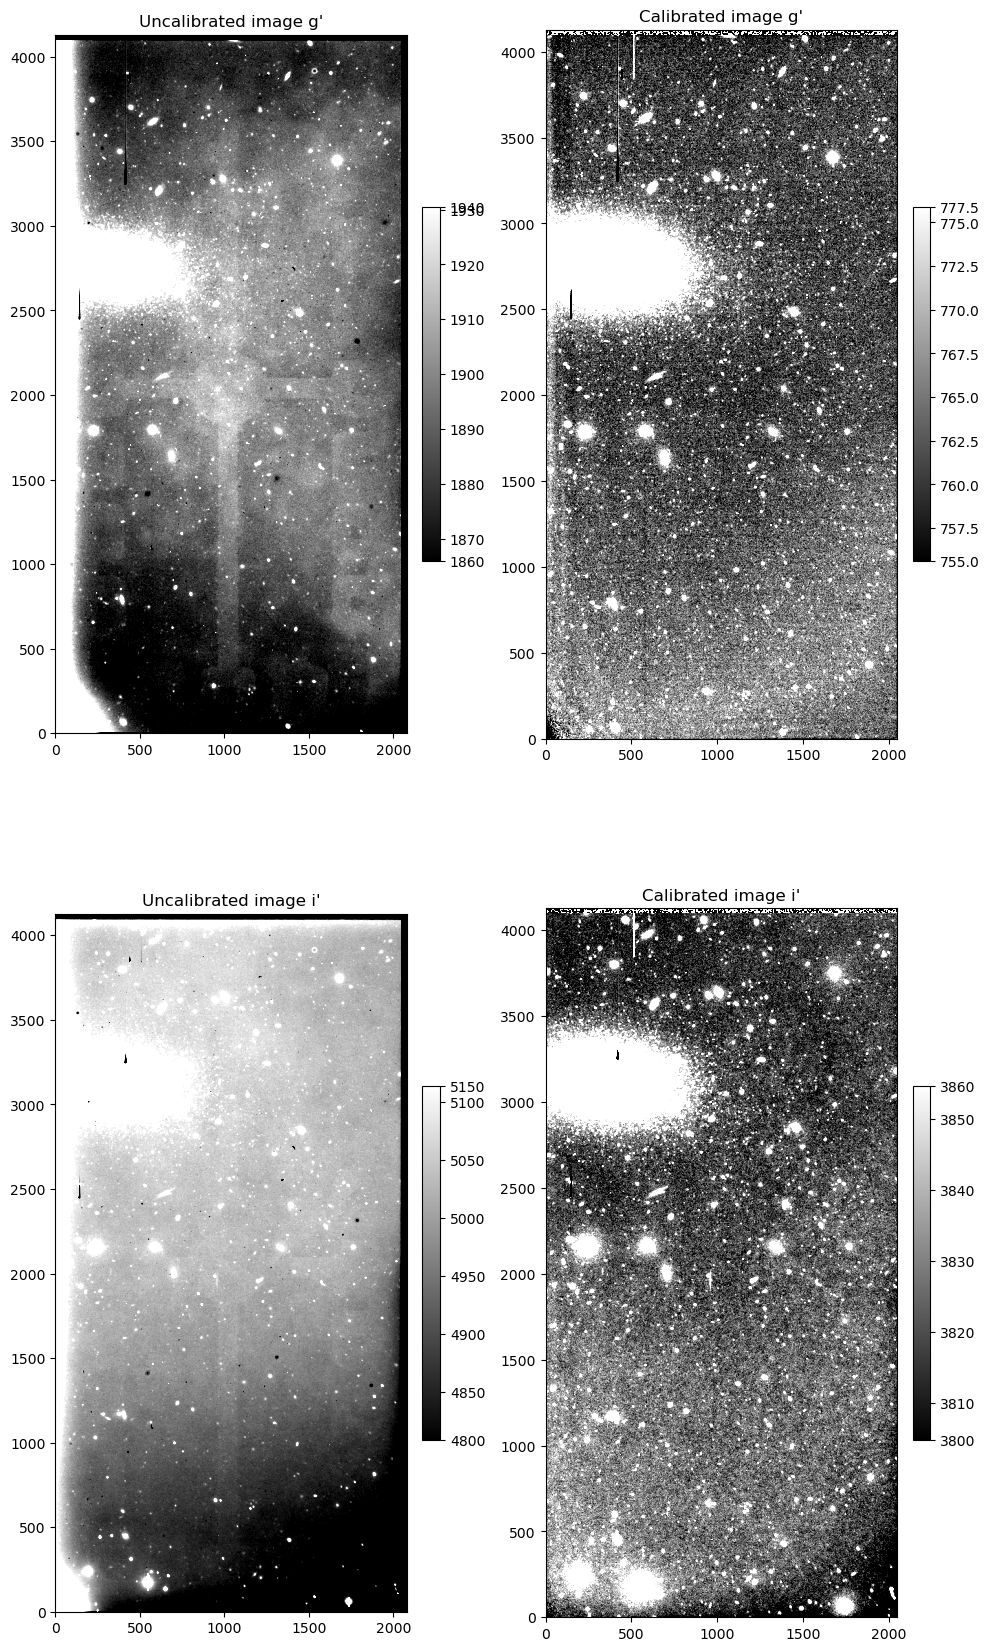

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(10, 20), tight_layout=True)

for row, raw_science_image in enumerate(light_ccds):
    filt = raw_science_image.header['filter']
    axes[row, 0].set_title('Uncalibrated image {}'.format(filt))
    show_image(raw_science_image, cmap='gray', ax=axes[row, 0], fig=fig, percl=90)

    axes[row, 1].set_title('Calibrated image {}'.format(filt))
    show_image(all_reds[row].data, cmap='gray', ax=axes[row, 1], fig=fig, percl=90)